In [22]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import time
import pandas as pd

service = Service(ChromeDriverManager().install())
options = webdriver.ChromeOptions()
options.add_argument("--disable-gpu")

driver = webdriver.Chrome(service=service, options=options)

# Ganti dengan URL halaman review toko di Tokopedia
url = "https://play.google.com/store/apps/details?id=com.tokopedia.tkpd&hl=id"

driver.get(url)

reviews = []
count = 1

try:
    review_button = driver.find_element(By.CSS_SELECTOR, 'button[ class="VfPpkd-LgbsSe VfPpkd-LgbsSe-OWXEXe-dgl2Hf ksBjEc lKxP2d LQeN7 aLey0c" ]')
    review_button.click()
    time.sleep(2)
    print("clicking")
    
    scroll_count = 0
    while scroll_count < 30 :
        scroll = driver.find_element(By.CLASS_NAME, 'odk6He')
        driver.execute_script("arguments[0].scrollIntoView({behavior: 'smooth', block: 'end'});", scroll)
        time.sleep(2)
        scroll_count = scroll_count + 1
except:
    print("There is nothing")

while count < 100:
    # Ambil elemen review
    time.sleep(3)  # Tunggu halaman masuk
    soup = BeautifulSoup(driver.page_source, "html.parser")
    try:
        review_elements = soup.findAll("div", attrs={'class':'RHo1pe'})

        for review in review_elements:
            username = review.find("div", attrs={"class":"X5PpBb"}).text
            comment = review.find("div", attrs={"class":"h3YV2d"}).text
            
            reviews.append({
                "username": username,
                "review": comment
            })
            print(count)
            count=count + 1
            
    except:
        print("there is error")


driver.quit()

# Simpan ke CSV
df = pd.DataFrame(reviews)
df.to_csv("tokopedia_review.csv", index=False)
print("Scraping selesai! Data disimpan dalam tokopedia_reviews.csv")

clicking


C:\Users\user\AppData\Local\Temp\ipykernel_15228\2118099918.py:43: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  review_elements = soup.findAll("div", attrs={'class':'RHo1pe'})


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [23]:
import pandas as pd
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re

# Load data hasil scraping
df = pd.read_csv("tokopedia_review.csv")

# Tampilkan contoh data
print("data dari csv: ")
print(df.head())

# Inisialisasi stopword remover & stemmer
stopword_factory = StopWordRemoverFactory()
stopword_remover = stopword_factory.create_stop_word_remover()
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

# Fungsi preprocessing
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Hapus karakter spesial
    text = stopword_remover.remove(text)  # Hapus stopword
    text = stemmer.stem(text)  # Stemming
    return text

# Terapkan ke data
df["clean_review"] = df["review"].astype(str).apply(clean_text)

slang_dict = {
    "yg": "yang",
    "bgt": "banget",
    "tdk": "tidak",
    "gk": "gak",
    "trs": "terus",
    "bnr2": "benar-benar",
    "kayu2": "kayu-kayu",
    "sukaaa": "sukaaa",
    "jd" : "jadi",
    "byk2" : "banyak",
    "mantaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaap": "mantap",
    "bsnahabbaabananananananananananananananannaannaananan":""
}

def normalize_slang(text):
    words = text.split()
    words = [slang_dict[word] if word in slang_dict else word for word in words]
    return " ".join(words)

df["clean_review"] = df["clean_review"].apply(normalize_slang)
print(df.head())

# Save preprocessed data
df.to_csv("preprocessed_reviews_spacy.csv", index=False)
print("Preprocessing complete! Data saved as preprocessed_reviews_spacy.csv")

data dari csv: 
        username                                             review
0     chriz mary  Saya edit bintangnya!! Tolong yah diperbaiki d...
1    Kroco Mumet  Sejak update, sekarang tidak lagi terlihat kap...
2     Yulia Dewi  Tokopedia media belanja online yang super pali...
3  Miftahul Ilmi  Banyak diskon dan promo, entah krn pengguna ba...
4     Embun Pagi  Baru pertama transaksi setelah pembayaran via ...
        username                                             review  \
0     chriz mary  Saya edit bintangnya!! Tolong yah diperbaiki d...   
1    Kroco Mumet  Sejak update, sekarang tidak lagi terlihat kap...   
2     Yulia Dewi  Tokopedia media belanja online yang super pali...   
3  Miftahul Ilmi  Banyak diskon dan promo, entah krn pengguna ba...   
4     Embun Pagi  Baru pertama transaksi setelah pembayaran via ...   

                                        clean_review  
0  edit bintang yah baik dulu masa foto bujti kir...  
1  sejak update sekarang lagi lihat kap

In [25]:
import spacy

# Load SpaCy's English model
nlp = spacy.load("xx_ent_wiki_sm")

def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

df["entities"] = df["clean_review"].astype(str).apply(extract_entities)
print(df.head())

df.to_csv("entities_review.csv", index=False)
print("Preprocessing complete! Data saved as entities_review.csv")

        username                                             review  \
0     chriz mary  Saya edit bintangnya!! Tolong yah diperbaiki d...   
1    Kroco Mumet  Sejak update, sekarang tidak lagi terlihat kap...   
2     Yulia Dewi  Tokopedia media belanja online yang super pali...   
3  Miftahul Ilmi  Banyak diskon dan promo, entah krn pengguna ba...   
4     Embun Pagi  Baru pertama transaksi setelah pembayaran via ...   

                                        clean_review  \
0  edit bintang yah baik dulu masa foto bujti kir...   
1  sejak update sekarang lagi lihat kapan akhir j...   
2  tokopedia media belanja online super paling la...   
3  banyak diskon promo entah krn guna baru enggak...   
4  baru pertama transaksi bayar via transfer bank...   

                                            entities  
0  [(terima aja, PER), (satu2 tau2, MISC), (apa2a...  
1  [(sejak, PER), (lagi lihat, PER), (bahkan bata...  
2  [(tokopedia media, MISC), (cancel belanja, PER...  
3               

In [26]:
import networkx as nx
from pyvis.network import Network

G = nx.Graph()


for index, row in df.iterrows():
    user = row["username"]
    review = row["clean_review"]
    entities = row["entities"]

    G.add_node(user, type="user", label=user, color="blue")
    # Track ORG entities
    org_entities = [ent_text for ent_text, ent_label in entities if ent_label == "ORG"]

    # Add entity nodes and edges
    for ent_text, ent_label in entities:
        if ent_text not in G.nodes:
            G.add_node(ent_text, type=ent_label, label=ent_text, color="red" if ent_label == "ORG" else "orange")

        # Connect User → Entity
        G.add_edge(user, ent_text, relation="mentioned")

# Visualisasi Knowledge Graph
net = Network(notebook=True, height="800px", width="100%", bgcolor="#222222", font_color="white")
net.from_nx(G)

# Tambahkan fitur interaktif
net.toggle_physics(True)  # Aktifkan fisika agar node tidak tumpang tindih
net.force_atlas_2based(gravity=-50, central_gravity=0.01)  # Sesuaikan gaya tarik antar node

# Simpan ke file HTML dan tampilkan
net.show("knowledge_graph.html")

knowledge_graph.html


In [27]:
# Convert nodes and edges into sentences
def graph_to_text(graph):
    text_data = []
    for node in graph.nodes():
        relations = [f"{node} is related to {nbr} via {graph[node][nbr]['relation']}"
                     for nbr in graph.neighbors(node)]
        text_data.extend(relations)
    return text_data

text_corpus = graph_to_text(G)
print(text_corpus)

['chriz mary is related to terima aja via mentioned', 'chriz mary is related to satu2 tau2 via mentioned', 'chriz mary is related to apa2an via mentioned', 'chriz mary is related to malah template via mentioned', 'chriz mary is related to bukan tanya yang jelas kurir via mentioned', 'chriz mary is related to jadi kaya via mentioned', 'chriz mary is related to malah klbikin kecewa via mentioned', 'terima aja is related to chriz mary via mentioned', 'satu2 tau2 is related to chriz mary via mentioned', 'apa2an is related to chriz mary via mentioned', 'malah template is related to chriz mary via mentioned', 'bukan tanya yang jelas kurir is related to chriz mary via mentioned', 'jadi kaya is related to chriz mary via mentioned', 'malah klbikin kecewa is related to chriz mary via mentioned', 'Kroco Mumet is related to sejak via mentioned', 'Kroco Mumet is related to lagi lihat via mentioned', 'Kroco Mumet is related to bahkan batal otomatis via mentioned', 'Kroco Mumet is related to jual akh

In [28]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

# Load embedding model
embedder = SentenceTransformer("all-MiniLM-L6-v2")

# Convert text corpus to embeddings
embeddings = embedder.encode(text_corpus)
embeddings = np.array(embeddings).astype("float32")

# Create FAISS index
index = faiss.IndexFlatL2(embeddings.shape[1])  # L2 distance (cosine similarity)
index.add(embeddings)

print(f"FAISS Index contains {index.ntotal} vectors")

FAISS Index contains 3960 vectors


In [36]:
def retrieve_knowledge(query, top_k=3):
    query_embedding = embedder.encode([query]).astype("float32")
    distances, indices = index.search(query_embedding, top_k)
    
    retrieved_info = [text_corpus[idx] for idx in indices[0] if idx < len(text_corpus)]
    return retrieved_info

query = "chriz mary"
retrieved = retrieve_knowledge(query)
print("Retrieved Knowledge:", retrieved)

Retrieved Knowledge: ['chriz mary is related to jadi kaya via mentioned', 'chriz mary is related to terima aja via mentioned', 'chriz mary is related to malah template via mentioned']


In [ ]:
import pandas as pd

# Sample ground truth dataset
ground_truth = {
    "chriz mary": ["chriz mary is related to terima aja via mentioned", "chriz mary is related to jadi kaya via mentione", "chriz mary is related to malah klbikin kecewa via mentioned"]
}

# Define retrieval functions (Vector, Graph, Hybrid)
def retrieve_vector(query, top_k=3):
    """Retrieve results using FAISS Vector Search"""
    query_embedding = embedder.encode([query], normalize_embeddings=True).astype("float32")
    distances, indices = index.search(query_embedding, top_k)
    return [text_corpus[idx] for idx in indices[0] if 0 <= idx < len(text_corpus)]

def retrieve_graph(query):
    """Retrieve results using Knowledge Graph Search"""
    if query not in G:
        return [f"⚠️ '{query}' not found in Knowledge Graph"]
    
    return [f"{query} is related to {nbr} via {G[query][nbr]['relation']}" for nbr in G.neighbors(query)]

def retrieve_hybrid(query, top_k=3):
    """Combine Vector & Graph-based methods"""
    vector_results = retrieve_vector(query, top_k)
    graph_results = retrieve_graph(query)
    return list(set(vector_results + graph_results))  # Remove duplicates

# Evaluation function
def evaluate_retrieval(query, retrieved):
    expected_answers = ground_truth.get(query, [])
    
    if not expected_answers:
        return {"AC": None, "CP": None, "CR": None}  # Handle missing ground truth

    retrieved_set = set(retrieved)
    expected_set = set(expected_answers)

    correct_answers = retrieved_set.intersection(expected_set)
    
    answer_correctness = len(correct_answers) / max(len(retrieved_set), 1)
    context_precision = len(correct_answers) / max(len(retrieved_set), 1)
    context_recall = len(correct_answers) / max(len(expected_set), 1)

    return {
        "AC": round(answer_correctness, 3),
        "CP": round(context_precision, 3),
        "CR": round(context_recall, 3),
    }

# Define queries to evaluate
queries = ["chriz mary"]

# Store results in DataFrame
results = []

for query in queries:
    vector_results = retrieve_vector(query)
    graph_results = retrieve_graph(query)
    hybrid_results = retrieve_hybrid(query)

    vector_eval = evaluate_retrieval(query, vector_results)
    graph_eval = evaluate_retrieval(query, graph_results)
    hybrid_eval = evaluate_retrieval(query, hybrid_results)

    results.append(["Vector-based", query, vector_eval["AC"], vector_eval["CP"], vector_eval["CR"]])
    results.append(["Graph-based", query, graph_eval["AC"], graph_eval["CP"], graph_eval["CR"]])
    results.append(["Hybrid", query, hybrid_eval["AC"], hybrid_eval["CP"], hybrid_eval["CR"]])

# Convert results to DataFrame
df_results = pd.DataFrame(results, columns=["Method", "Query", "Answer Correctness", "Context Precision", "Context Recall"])

# Save results to CSV
df_results.to_csv("evaluation_comparison.csv", index=False)

Tabel Perbandingan:
   Answer Correctness  Context Precision  Context Recall
0               0.333              0.333           0.333
1               0.286              0.286           0.667
2               0.286              0.286           0.667


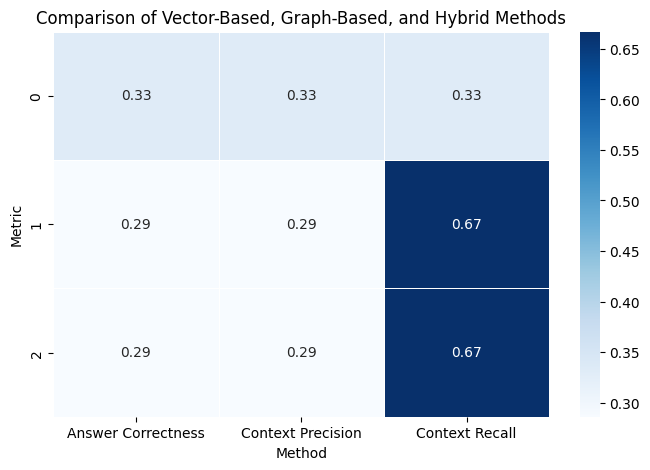

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Parameter yang diukur
parameters = ["Answer Correctness", "Context Precision", "Context Recall"]

# Metode yang dibandingkan
methods = ["Vector-Based", "Graph-Based", "Hybrid"]

# Membuat DataFrame
comparison_df = pd.DataFrame(results, index=parameters)

# Select only numeric columns for heatmap
numeric_df = df_results.drop(columns=["Method", "Query"])  # Drop non-numeric columns if they exist

# Menampilkan tabel
print("Tabel Perbandingan:")
print(numeric_df)

# Plot visualisasi
plt.figure(figsize=(8, 5))
sns.heatmap(numeric_df, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.title("Comparison of Vector-Based, Graph-Based, and Hybrid Methods")
plt.xlabel("Method")
plt.ylabel("Metric")
plt.show()